# Create yearly mill usage profile based on measured usage

This notebook will follow a very similar approach to the welder notebook here: https://github.com/RadiantLabs/microgrid-appliance-analysis/blob/master/scripts/usage_profiles/welder_usage_profile.ipynb 

I will include a lot less context in this notebook for now. I can fill it out later if needed.

### Definitions
**Usage Profile**: A usage profile is a unitless series of how often the mill is used on an hourly basis throughout a year. Being unitless allows us to apply costs, power or other factors to generate load, throughput or cost profiles. 

**day_hour**: Monday at 2pm is a single `day_hour` for example. Monday at 3pm is a different `day_hour`. There are 24 hours x 7 days = 168 `day_hour`s.

### General Steps
1. Import measured usage data from a mill. This data is in 2 minute increments and the number of mill revolutions every 2 minutes.
2. Create a unitless utilization factor based on RPM. Create a separate factor for both kW and grain throughput.
3. Resample 2 minute data to 1 hour data, summing new utilization factors. 
4. Group data by `day_hour`s and export for web app
5. Generate a yearly profile by randomly sampling measured `day_hour`s and applying them to the rest of the year.
6. Compare stats of yearly usage profile to measured usage profile to make sure we made reasonable assumptions

We probably don't need to interpolate, since we have 5-6 measured values per `day_hour`

### Questions and TODOs
* Set column header for datetime (app needs this)
* Set hour_of_year to Hour (app needs this)
* Is Timestamp in GMT? I am assumed it is. If not this is easy to fix
* Understand why operators run mills consistently at half RPMs or what the full rated load is:
> Amanda: is the engine running harder than full rated load during these times? I think so, because it would then mean that most of the activity is happening around 80% of full rated load, which is normal for a diesel engine
* Find performance curves:
    1. rpm-to-power: From common mills (https://www.alibaba.com/product-detail/Changfa-type-20-hp-S1115-single_60629667381.html?spm=a2700.7724857.normalList.30.48f321e0kzd6H9), we can see that 16.2kW = 2200 RPM which would imply this mill is running at half speed most of the time. Also, we don't know the kW at 1100 where these mills are mostly running 
    2. rpm-to-grain-throughput


### Running this notebook
Jupyter notebooks are very flexible but have problems with out-of-order function executions.
For example, dropping a column once and then trying to drop the same column again because
you're evaluating the same cell will throw an error. 

Go to Cell > Run All from the menu often or if having problems. For final output, always run it.

## Setup & Library Imports

In [227]:
# Reset all variables so that we can 'run all cells' and not get unused variables hanging around
%reset -f

# Most of this comes with anaconda distribution. I thinkt the only one 
# you have to install is:
# conda install pivottablejs
import pandas as pd
from scipy.stats import mode
from pivottablejs import pivot_ui
from collections import defaultdict
from functools import partial
import random
import json
import pytz

# Should have pandas 0.23 or greater. If not and you're using Anaconda for packages, 
# do this in the terminal: `conda update pandas`
pd.__version__    

'0.23.4'

## Import Mill Data

In [228]:
# Uncomment / comment based on the mill you want to analyze

## Rice Mill
excel_file_path = 'inputs/RiceHulling_LP_Tanzania 20180908-20181018.xlsx'
sheet_name = 'RiceHulling_LP_Tanzania'
output_generator_kw_data_name = 'output/rice_mill_kw_generator_data.json'
output_generator_grain_data_name = 'output/rice_mill_grain_generator_data.json'
output_profile_name = 'output/rice_mill_usage_profile.csv'

## Maize Mill
# excel_file_path = 'inputs/MaizeMilling_LP_Tanzania 20180907-20180930.xlsx'
# sheet_name = 'MaizeMilling_LP_Tanzania 201809'
# output_generator_kw_data_name = 'output/maize_mill_kw_generator_data.json'
# output_generator_grain_data_name = 'output/maize_mill_grain_generator_data.json'
# output_profile_name = 'output/maize_mill_usage_profile.csv'

In [229]:
# Import Excel file, specify the sheet & import it into a Pandas Dataframe.
# df is short for Pandas DataFrame - it makes it clearer what this datastructure is
df_measured_2min = pd.read_excel(excel_file_path, sheet_name=sheet_name)

# Rename columns so they are shorter and easier to work with.
df_measured_2min = df_measured_2min.rename(columns={'Timestamp': 'time_gmt', 'Value RPM for 2 min)': '2min_count'})

# Keep only relevant columns
df_measured_2min = df_measured_2min[['time_gmt', '2min_count']]
df_measured_2min.head()

,time_gmt,2min_count
0,2018-09-07 08:38:44,0
1,2018-09-07 08:40:44,0
2,2018-09-07 08:42:44,0
3,2018-09-07 08:44:44,0
4,2018-09-07 08:46:44,0


In [230]:
# (rows, columns)
df_measured_2min.shape 

(30292, 2)

## Convert Timezone

In [231]:
# To see all timezones available (but select only the first 55 to see Africa): 
# pytz.all_timezones[0:55]  

In [232]:
# There was no Tanzania listed. Nairobi is +3 which is the same as Tanzania
# There should not be a problem with daylight savings time - from my research neither observe it
tanzania_tz = pytz.timezone('Africa/Nairobi')

In [233]:
# Convert date string to proper datetime so we can work with timezones
df_measured_2min['time_gmt'] = pd.to_datetime(df_measured_2min['time_gmt'])

In [234]:
# Add local time
df_measured_2min['time_local'] = df_measured_2min['time_gmt'].dt.tz_localize('utc').dt.tz_convert(tanzania_tz)
df_measured_2min = df_measured_2min
df_measured_2min.head()

,time_gmt,2min_count,time_local
0,2018-09-07 08:38:44,0,2018-09-07 11:38:44+03:00
1,2018-09-07 08:40:44,0,2018-09-07 11:40:44+03:00
2,2018-09-07 08:42:44,0,2018-09-07 11:42:44+03:00
3,2018-09-07 08:44:44,0,2018-09-07 11:44:44+03:00
4,2018-09-07 08:46:44,0,2018-09-07 11:46:44+03:00


In [235]:
# Helper functions for making and matching day_hour columns

def shorten_day_name(day_string):
    """Shorten a day name to the first 4 letters (1Saturday => 1sat)
    This requires a string passed in.
    """
    return day_string[0:4].lower()

def composite_val(day_name, hour):
    """Generate a composite string value that can be used for dictionary 
    keys or other uses.
    For example, 1Saturday at 10am => 1sat_10
    """
    padded_hour = str(hour).zfill(2)
    return "{}_{}".format(shorten_day_name(day_name), padded_hour)

## Calculate RPM
The mill sensor measures rotations every 2 minutes. Calculate RPMs by dividing by 2

In [236]:
def count_to_rpm(count):
    return round(count / 2)

df_measured_2min['rpm'] = df_measured_2min['2min_count'].apply(count_to_rpm)
df_measured_2min.sample(10)

,time_gmt,2min_count,time_local,rpm
12979,2018-09-25 08:51:06,1996,2018-09-25 11:51:06+03:00,998
23432,2018-10-09 20:49:44,0,2018-10-09 23:49:44+03:00,0
8694,2018-09-19 10:07:17,0,2018-09-19 13:07:17+03:00,0
2311,2018-09-10 13:36:33,0,2018-09-10 16:36:33+03:00,0
15441,2018-09-28 18:42:16,0,2018-09-28 21:42:16+03:00,0
1685,2018-09-09 16:44:33,0,2018-09-09 19:44:33+03:00,0
11640,2018-09-23 12:13:06,0,2018-09-23 15:13:06+03:00,0
25557,2018-10-12 19:39:44,0,2018-10-12 22:39:44+03:00,0
425,2018-09-07 22:48:44,0,2018-09-08 01:48:44+03:00,0
18973,2018-10-03 16:26:16,0,2018-10-03 19:26:16+03:00,0


## Explore Data

In [237]:
# The data is skewed because most of it is zeros:
df_measured_2min.describe()

,2min_count,rpm
count,30292.000000,30292.000000
mean,148.044005,74.021425
std,516.505556,258.252519
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,2242.000000,1121.000000


In [238]:
# Filter out all zeros and very low RPMs and look at it again:
# df_measured_nozeros = df_measured_2min[df_measured_2min['rpm'] > -100]  # temp: effectively doesn't filter
df_measured_nozeros = df_measured_2min[df_measured_2min['rpm'] > 100]
df_measured_nozeros.sample(10)

,time_gmt,2min_count,time_local,rpm
14425,2018-09-27 09:03:06,1986,2018-09-27 12:03:06+03:00,993
1412,2018-09-09 07:38:33,2069,2018-09-09 10:38:33+03:00,1034
7790,2018-09-18 04:05:42,889,2018-09-18 07:05:42+03:00,444
18047,2018-10-02 09:34:16,340,2018-10-02 12:34:16+03:00,170
10696,2018-09-22 04:51:17,921,2018-09-22 07:51:17+03:00,460
29521,2018-10-18 07:47:44,2101,2018-10-18 10:47:44+03:00,1050
17147,2018-10-01 03:34:16,2032,2018-10-01 06:34:16+03:00,1016
9231,2018-09-20 04:01:17,2147,2018-09-20 07:01:17+03:00,1074
20902,2018-10-06 08:44:16,2194,2018-10-06 11:44:16+03:00,1097
12175,2018-09-24 06:03:06,1058,2018-09-24 09:03:06+03:00,529


In [239]:
# pivot_ui(df_measured_nozeros, 
#          rows=['2min_count'],
#          rendererName="Table",
#          aggregatorName="Count")

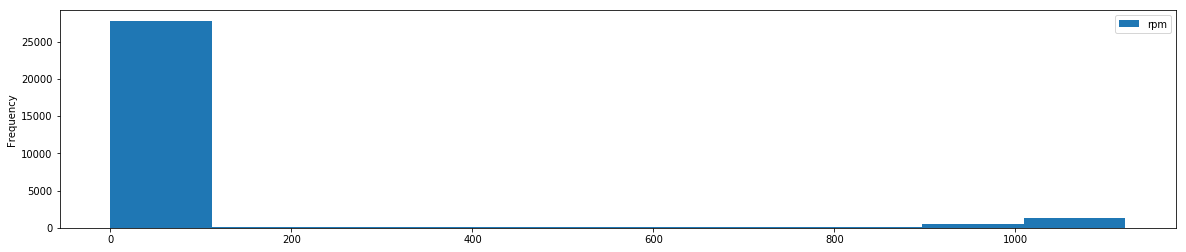

In [240]:
# Plot histogram of rpm including zeros
df_measured_2min.plot.hist(y='rpm', figsize=(20, 4))

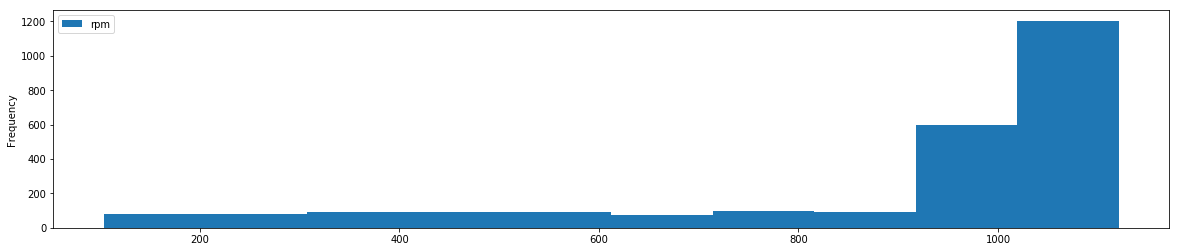

In [241]:
# Plot histogram of rpm excluding zeros and low RPMs
df_measured_nozeros.plot.hist(y='rpm', figsize=(20, 4))

In [242]:
# Most common value (mode):
df_measured_nozeros['rpm'].value_counts().idxmax()

1048

In [243]:
# Add day, hour_of_day, day_hour to 2 minute intervals to see the variation in RPMs with different time intervals
# First set index of dataframe to time_local
df_measured_nozeros = df_measured_nozeros.set_index('time_local')

In [267]:
df_measured_nozeros['day'] = df_measured_nozeros.index.dayofweek.map(str) + df_measured_nozeros.index.day_name()
df_measured_nozeros['day'] = df_measured_nozeros["day"].apply(shorten_day_name)
df_measured_nozeros['hour_of_day'] = df_measured_nozeros.index.hour
df_measured_nozeros['day_hour'] = df_measured_nozeros.apply(lambda row: composite_val(row['day'], row['hour_of_day']), axis=1)
df_measured_nozeros['week'] = df_measured_nozeros.index.week
df_measured_nozeros['rpm_binned'] = pd.cut(df_measured_nozeros['rpm'], 5, precision=0, )
df_measured_nozeros.sample(10)

,time_gmt,2min_count,rpm,day,hour_of_day,day_hour,week,rpm_binned
time_local,,,,,,,,
2018-10-03 04:54:16+03:00,2018-10-03 01:54:16,1893,946,2wed,4,2wed_04,40,"(918.0, 1121.0]"
2018-10-10 01:13:44+03:00,2018-10-09 22:13:44,2223,1112,2wed,1,2wed_01,41,"(918.0, 1121.0]"
2018-10-17 12:05:44+03:00,2018-10-17 09:05:44,1539,770,2wed,12,2wed_12,42,"(714.0, 918.0]"
2018-09-26 13:09:06+03:00,2018-09-26 10:09:06,1495,748,2wed,13,2wed_13,39,"(714.0, 918.0]"
2018-10-19 10:53:44+03:00,2018-10-19 07:53:44,1261,630,4fri,10,4fri_10,42,"(511.0, 714.0]"
2018-10-10 08:23:44+03:00,2018-10-10 05:23:44,2191,1096,2wed,8,2wed_08,41,"(918.0, 1121.0]"
2018-10-12 10:35:44+03:00,2018-10-12 07:35:44,2194,1097,4fri,10,4fri_10,41,"(918.0, 1121.0]"
2018-09-16 11:25:42+03:00,2018-09-16 08:25:42,2061,1030,6sun,11,6sun_11,37,"(918.0, 1121.0]"
2018-09-21 03:01:17+03:00,2018-09-21 00:01:17,753,376,4fri,3,4fri_03,38,"(307.0, 511.0]"


In [265]:
pivot_ui(df_measured_nozeros, 
         rows=['rpm_binned'],
         cols=['hour_of_day'],
         rendererName="Bar Chart",
         aggregatorName="Count")

In [246]:
pivot_ui(df_measured_nozeros, 
         rows=['rpm_binned'],
         cols=['day'],
         rendererName="Bar Chart",
         aggregatorName="Count")

#### Thoughts
* We're seeing the RPM average and mode as ~1000. We think the max RPM is 2200. We are measuring rotations every 2 minutes but 2 minutes is fairly long. Is it possible these mills cycle on and off (or low rpms) within those 2 minutes? For example, they could run at max for 30 seconds, spin down to low RPMs for 30, then spin back up to max continuously? 
    1. The data could support that type of cycling if that behavior was programmed into the mill
    2. The data is too consistent to support people manually cycling these mills. I would expect more variance in the distributions of RPMs.

## Approach to convert RPM to unitless usage counts
RPMs relate to 3 quantities that we care about:
* kW
* kWh
* Grain throughput

These quantities are directly related to costs and revenue for the appliance owner and grid operator. We have measured revolution count in 2-minute intervals. The average RPM is half the number of mill revolutions.

However, if we want to work with hourly intervals, then we can't add up RPMs to get the total RPMs within an hour. We have a few options:
1. Average the RPMs across the hour. If the mill runs for 30 minutes at 1200 RPMs, then the average would be 600 RPMs. Grain throughput and kW likely have a non-linear relationship to RPMs, so this would really distort the results.
2. Assign a unitless usage factor to each minute interval. If the mill is running at full production (throughput and kW), then we can assign it a value of 1 (2 for a 2-minute interval). We can scale the factor down as the RPMs go down. 

The second approach is what I will use.

### Throughput vs. kW
To calculate kW (and therefore kWh) and throughput, we need to know how RPM relates to these two factors. There is no reason to assume the kW and grain throughput vs RPM scale the same. So let's create two functions that calculate kW and grain throughput independently.

For now, these factors will be the same. But the functions can be easily modified as we get more information without refactoring code downstream.

## RPM to unitless utilization factors
This mill is likely rated at 16.2kW @ 2200 RPM. Let's assume some function that relates it's utilization given an RPM.

In [247]:
# Until we can get ahold of performance curves for rpm vs kW and rpm vs throughput,
# let's take an educated guess at how they relate.
# We may want to filter very low RPMs out. A slow motor still uses power and mills grain, 
# so I don't know what the cutoff would be.

# This is the function from Amanda's spreadsheet. 
def rpm_to_kw_utilization(rpm, full_capacity=1110):
    """
    Convert RPM to a kW utilization factor. 
    """
    return round(rpm / full_capacity, 5)

rpm_to_kw_utilization(1121)

1.00991

In [248]:
# Until we have better data, assume the utilization factors are the 
# same between kW and grain
def rpm_to_grain_utilization(rpm, full_capacity=1110):
    """
    Convert RPM to a grain milled utilization factor
    """
    return round(rpm / full_capacity, 5)

rpm_to_grain_utilization(1121)

1.00991

In [249]:
# The utilization factors relate RPMs to kW (or throughput) for *one minute*.
# We are working with 2 minute intervals, so we need to account for both
# minutes of usage by multiplying the factor by 2.
df_measured_2min['kw_factor'] = df_measured_2min['rpm'] \
                                        .apply(rpm_to_kw_utilization) \
                                        .apply(lambda factor: 2 * factor)
df_measured_2min['grain_factor'] = df_measured_2min['rpm'] \
                                        .apply(rpm_to_grain_utilization) \
                                        .apply(lambda factor: 2 * factor)
df_measured_2min[30279:30290]

,time_gmt,2min_count,time_local,rpm,kw_factor,grain_factor
30279,2018-10-19 09:03:44,0,2018-10-19 12:03:44+03:00,0,0.00000,0.00000
30280,2018-10-19 09:05:44,0,2018-10-19 12:05:44+03:00,0,0.00000,0.00000
30281,2018-10-19 09:07:44,324,2018-10-19 12:07:44+03:00,162,0.29190,0.29190
30282,2018-10-19 09:09:44,2150,2018-10-19 12:09:44+03:00,1075,1.93694,1.93694
30283,2018-10-19 09:11:44,2156,2018-10-19 12:11:44+03:00,1078,1.94234,1.94234
30284,2018-10-19 09:13:44,2143,2018-10-19 12:13:44+03:00,1072,1.93154,1.93154
30285,2018-10-19 09:15:44,2150,2018-10-19 12:15:44+03:00,1075,1.93694,1.93694
30286,2018-10-19 09:17:44,2165,2018-10-19 12:17:44+03:00,1082,1.94954,1.94954
30287,2018-10-19 09:19:44,2152,2018-10-19 12:19:44+03:00,1076,1.93874,1.93874
30288,2018-10-19 09:21:44,1902,2018-10-19 12:21:44+03:00,951,1.71352,1.71352


## Resample 2 minute to hourly intervals

In [250]:
# First we need to set the dataframe index to be the time_local datetime
df_measured_2min_index = df_measured_2min.set_index('time_local')
df_measured_2min_index[30279:30283]

,time_gmt,2min_count,rpm,kw_factor,grain_factor
time_local,,,,,
2018-10-19 12:03:44+03:00,2018-10-19 09:03:44,0,0,0.00000,0.00000
2018-10-19 12:05:44+03:00,2018-10-19 09:05:44,0,0,0.00000,0.00000
2018-10-19 12:07:44+03:00,2018-10-19 09:07:44,324,162,0.29190,0.29190
2018-10-19 12:09:44+03:00,2018-10-19 09:09:44,2150,1075,1.93694,1.93694


In [251]:
df_measured_2min_index.shape

(30292, 5)

In [252]:
# Resample while summing every 2-min interval within an hour ('H')
# Drop the now-unused 2min_count
# GMT time will automatically be dropped since you can't sum it
df_measured = df_measured_2min_index.resample('H').sum().drop(columns=['2min_count'])

df_measured.shape  # (rows, columns) where column count doesn't include the index

(1010, 3)

## Add hour, day of week, day_hour columns 
These columns will be used later for generating yearly usage profile and aggregate stats.

In [253]:
# Add the name of the day of the week to the dataframe (Saturday).
# Prepend that name with a number of the day of the week.
# Monday is 0, Tuesday is 1 and so on. This will allows tools to 
# order the days so they are in order: 0Monday, 1Tuesday, otherwise 
# they will be ordered alphabetical.
df_measured["day"] = df_measured.index.dayofweek.map(str) + df_measured.index.day_name()
df_measured["day"] = df_measured["day"].apply(shorten_day_name)

# Add hour of day (as a number)
df_measured['hour_of_day'] = df_measured.index.hour 

# Add day_hour. For example: 4fri_10
# Possible source of confusion: 
# 4fri is just friday. 4fri_10 is Friday at 10am. 
df_measured["day_hour"] = df_measured.apply(lambda row: composite_val(row['day'], row['hour_of_day']), axis=1)

df_measured.sample(10)

,rpm,kw_factor,grain_factor,day,hour_of_day,day_hour
time_local,,,,,,
2018-09-10 09:00:00+03:00,4595,8.27928,8.27928,0mon,9,0mon_09
2018-09-09 20:00:00+03:00,0,0.00000,0.00000,6sun,20,6sun_20
2018-10-13 03:00:00+03:00,6006,10.82160,10.82160,5sat,3,5sat_03
2018-09-22 21:00:00+03:00,0,0.00000,0.00000,5sat,21,5sat_21
2018-09-17 06:00:00+03:00,1010,1.81982,1.81982,0mon,6,0mon_06
2018-10-13 20:00:00+03:00,0,0.00000,0.00000,5sat,20,5sat_20
2018-09-15 21:00:00+03:00,0,0.00000,0.00000,5sat,21,5sat_21
2018-09-28 18:00:00+03:00,0,0.00000,0.00000,4fri,18,4fri_18
2018-09-09 19:00:00+03:00,0,0.00000,0.00000,6sun,19,6sun_19


## Generate data for yearly usage profile sampling

In [254]:
def create_usage_profile_data(df, column):
    """
    Create a dictionary, where each key is a day_hour and each value 
    is a list of measured usage factor values. 
    Takes a Pandas dataframe and returns a python dictionary that can be 
    encoded into JSON for other applications.
    We may be able to use groupby for a more succinct function, but this works
    """
    dict = defaultdict(list)
    for index, row in df.iterrows():
        key = row['day_hour']
        dict[key].append(row[column])
    return dict

In [255]:
measured_usage_kw_factors = create_usage_profile_data(df_measured, 'kw_factor')
measured_usage_kw_factors

defaultdict(list,
            {'0mon_00': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
             '0mon_01': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
             '0mon_02': [0.0, 10.668460000000001, 2.92072, 0.0, 0.0, 0.0],
             '0mon_03': [0.0, 0.0, 2.07206, 9.25224, 4.31532, 0.0],
             '0mon_04': [0.0, 0.0, 0.0, 0.0, 2.72794, 0.0],
             '0mon_05': [10.27206, 0.0, 0.0, 0.0, 11.679260000000001, 0.0],
             '0mon_06': [5.54234,
              1.81982,
              12.075680000000002,
              10.54954,
              0.0,
              0.0],
             '0mon_07': [0.0036, 0.0, 0.0, 6.409020000000001, 0.0, 3.45046],
             '0mon_08': [19.13698, 2.56218, 2.41802, 0.0, 3.6036, 0.0],
             '0mon_09': [8.27928,
              11.50092,
              1.86848,
              10.95678,
              1.01802,
              6.8018],
             '0mon_10': [19.410839999999997,
              29.52252,
              20.4829,
              16.268459999999997,
           

In [256]:
measured_usage_grain_factors = create_usage_profile_data(df_measured, 'grain_factor')
measured_usage_grain_factors

defaultdict(list,
            {'0mon_00': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
             '0mon_01': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
             '0mon_02': [0.0, 10.668460000000001, 2.92072, 0.0, 0.0, 0.0],
             '0mon_03': [0.0, 0.0, 2.07206, 9.25224, 4.31532, 0.0],
             '0mon_04': [0.0, 0.0, 0.0, 0.0, 2.72794, 0.0],
             '0mon_05': [10.27206, 0.0, 0.0, 0.0, 11.679260000000001, 0.0],
             '0mon_06': [5.54234,
              1.81982,
              12.075680000000002,
              10.54954,
              0.0,
              0.0],
             '0mon_07': [0.0036, 0.0, 0.0, 6.409020000000001, 0.0, 3.45046],
             '0mon_08': [19.13698, 2.56218, 2.41802, 0.0, 3.6036, 0.0],
             '0mon_09': [8.27928,
              11.50092,
              1.86848,
              10.95678,
              1.01802,
              6.8018],
             '0mon_10': [19.410839999999997,
              29.52252,
              20.4829,
              16.268459999999997,
           

## Export usage data for web app

In [257]:
with open(output_generator_kw_data_name, 'w') as fp:
    json.dump(measured_usage_kw_factors, fp)
    
with open(output_generator_grain_data_name, 'w') as fp:
    json.dump(measured_usage_grain_factors, fp)

## Generating yearly usage profile
Now that we have usage profile data, generate a complete year's usage profile

In [258]:
def create_year_range_df(year=2018):
    """
    Creates a dataframe with a full year's dates as the index. 
    Add extra derived columns based on that datetime index: 
    (hour_of_year, day, hour_of_day, day_hour).
    This dataframe does not contain any appliance data
    """
    start_date_str = '1/1/{}'.format(year + 1)
    start_date = pd.to_datetime(start_date_str) - pd.Timedelta(days=365)
    hourly_periods = 8760
    date_range = pd.date_range(start_date, periods=hourly_periods, freq='H')
    year_hours = list(range(len(date_range)))
    
    # Create a full year with a datetime index (8760 hours)
    df_year = pd.DataFrame({"hour_of_year": year_hours}, index=date_range)
    
    # Now add day of week, hour of day and day_hour columns
    df_year['day'] = df_year.index.dayofweek.map(str) + df_year.index.day_name()
    df_year['day'] = df_year["day"].apply(shorten_day_name)
    df_year['hour_of_day'] = df_year.index.hour
    df_year["day_hour"] = df_year.apply(lambda row: composite_val(row['day'], row['hour_of_day']), axis=1)
    return df_year

# Uncomment these to test results. 
# This function is called from generate_usage_profile() 
# df_year_example = create_year_range_df()
# df_year_example.head()

In [259]:
#df_year['kw_factor'] = df_year.apply(partial(sample_usage_index, kw_factor), axis=1)
# df_year['grain_factor'] = df_year.apply(partial(sample_usage_index, grain_factor), axis=1) 


def sample_usage_index(usage_factors, day_hour):
    """
    Takes the measured usage dictionary and a dataframe row
    from the empty yearly profile created in create_year_range_df. 
    Using the day_hour from that dataframe row, take a random
    sample of the same day_hour from the measured data.
    """
    choice_index_range = range(len(usage_factors[day_hour]))
    return random.choice(choice_index_range)
    

def generate_usage_profile(kw_factors, grain_factors, year=2018):
    """
    Generate a full year's usage profile by sampling measured data 
    Takes the measured usage dictionary for both kW and grain factor
    and optional year.
    Returns a dataframe of hourly intevals with sampled appliance values
    """
    # Create dataframe with a full year of hourly intervals
    df_year = create_year_range_df(year)

    # We need to make sure we take the same sample from both kw_factors and grain_factors
    # So instead of returning a factor from the sampling, return an index of the list of factors  
    for row_index, row in df_year.iterrows():
        day_hour = row['day_hour']
        usage_index = sample_usage_index(kw_factors, day_hour)
        
        # Add new columns with the sample values
        df_year.at[row_index, 'kw_factor'] = kw_factors[day_hour][usage_index]
        df_year.at[row_index, 'grain_factor'] = grain_factors[day_hour][usage_index]
        
    return df_year


df_generated_usage_profile = generate_usage_profile(measured_usage_kw_factors, measured_usage_grain_factors)
df_generated_usage_profile.head(10)

,hour_of_year,day,hour_of_day,day_hour,kw_factor,grain_factor
2018-01-01 00:00:00,0,0mon,0,0mon_00,0.00000,0.00000
2018-01-01 01:00:00,1,0mon,1,0mon_01,0.00000,0.00000
2018-01-01 02:00:00,2,0mon,2,0mon_02,0.00000,0.00000
2018-01-01 03:00:00,3,0mon,3,0mon_03,0.00000,0.00000
2018-01-01 04:00:00,4,0mon,4,0mon_04,2.72794,2.72794
2018-01-01 05:00:00,5,0mon,5,0mon_05,0.00000,0.00000
2018-01-01 06:00:00,6,0mon,6,0mon_06,1.81982,1.81982
2018-01-01 07:00:00,7,0mon,7,0mon_07,0.00000,0.00000
2018-01-01 08:00:00,8,0mon,8,0mon_08,0.00000,0.00000
2018-01-01 09:00:00,9,0mon,9,0mon_09,1.01802,1.01802


In [260]:
df_generated_usage_profile.describe()

,hour_of_year,hour_of_day,kw_factor,grain_factor
count,8760.000000,8760.000000,8760.000000,8760.000000
mean,4379.500000,11.500000,4.013787,4.013787
std,2528.938512,6.922582,8.251899,8.251899
min,0.000000,0.000000,0.000000,0.000000
25%,2189.750000,5.750000,0.000000,0.000000
50%,4379.500000,11.500000,0.000000,0.000000
75%,6569.250000,17.250000,3.520270,3.520270
max,8759.000000,23.000000,56.522580,56.522580


![Screenshot](screenshots/rice_mill_measured_hourly_avg.png)

![Screenshot](screenshots/rice_mill_generated_hourly_avg.png)

![Screenshot](screenshots/rice_mill_measured_daily_avg.png)

![Screenshot](screenshots/rice_mill_generated_daily_avg.png)

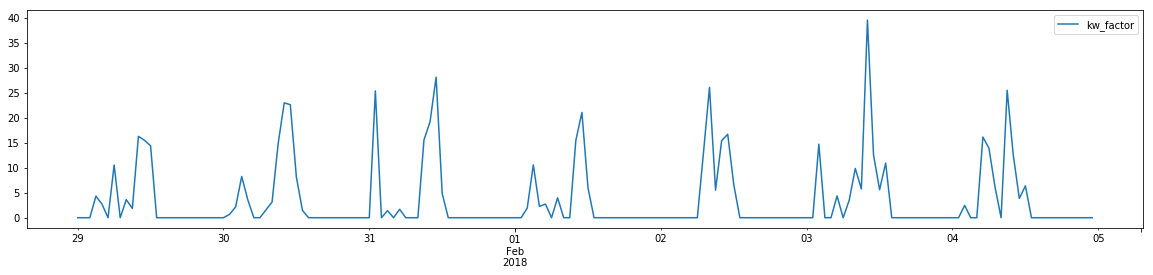

In [261]:
# Show a week's worth of mill usage:
df_week_6 = df_generated_usage_profile.loc[df_generated_usage_profile.index.week == 5]
df_week_6.plot(y='kw_factor', figsize=(20, 4))

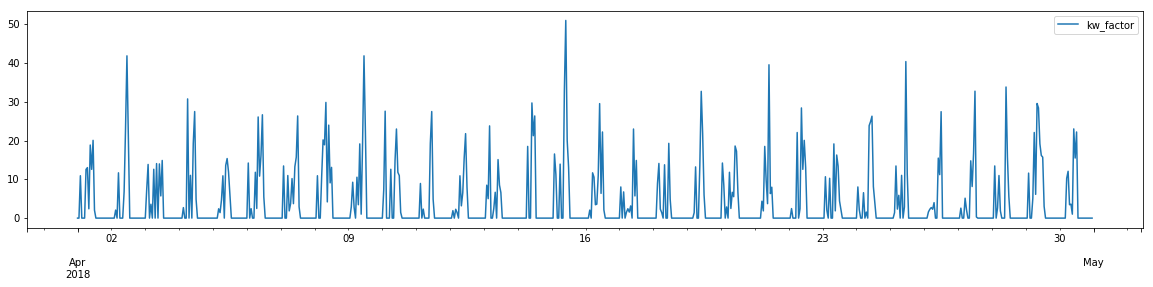

In [262]:
# Show a month's worth of mill usage:
df_february = df_generated_usage_profile.loc[df_generated_usage_profile.index.month == 4]
df_february.plot(y='kw_factor', figsize=(20, 4))

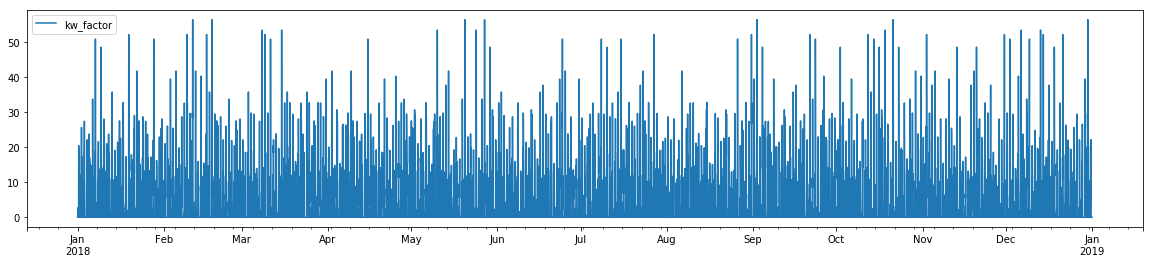

In [263]:
# Show entire year's worth of mill usage:
df_generated_usage_profile.plot(y='kw_factor', figsize=(20, 4))

## Export yearly usage profile 
The web app doesn't need this data but it can be used for other analysis

In [264]:
print("outputting to: ", output_profile_name)
df_generated_usage_profile.to_csv(output_profile_name)

outputting to:  output/rice_mill_usage_profile.csv
